In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
env = gym.make('Taxi-v3')

In [3]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Используем метод динамического программирования для оценки функции полезности действий

In [4]:
class MDP:
    def __init__(self, env):
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        P = np.zeros((n_states, n_actions), dtype=np.int32)
        R = np.zeros((n_states, n_actions))
        d = np.zeros((n_states, n_actions))
        for s in env.P.keys():
            for a in env.P[s].keys():
                assert len(env.P[s][a]) == 1
                for p, s1, r, done in env.P[s][a]:
                    assert p == 1
                    P[s, a] = s1
                    R[s, a] = r
                    d[s, a] = int(not done)
        self.n_states = P.shape[0]
        self.n_actions = P.shape[1]
        self.P = P
        self.R = R
        self.d = d
        
    def get_value(self, policy, gamma):
        """
        Args:
          policy ([n_states, n_actions]):
          gamma (float):
        """
        Q = np.zeros((self.n_states, self.n_actions))
        for i in range(100):
            Q = self.R + gamma * (Q * policy).sum(1)[self.P] * self.d
        return Q

In [5]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [6]:
mdp = MDP(env)

Функция `eps_greedy` выставляет для каждого состояния $s$ все вероятности действий равными $\frac{\varepsilon}{|\mathcal{A}|}$ кроме действия $\arg\max_a Q(s, a)$. Для него вероятность равна $1 - \varepsilon + \frac{\varepsilon}{|\mathcal{A}|}$. Таким образом, с вероятностью $1 - \varepsilon$, мы делаем лучшее действие, а с вероятностью $\varepsilon$ - случайное

In [7]:
def eps_greedy(Q, eps=0.1):
    policy = np.zeros((n_states, n_actions))
    # делаем все дейсвия равновероятными, вероятность по формуле ниже:
    policy[...] = eps / n_actions
    # вероятность действия на месте argmax_a Q(., a) равна 1 - epsilon + epsilon / n_actions
    np.put_along_axis(policy, Q.argmax(1)[:, None], (1 - eps) + eps / n_actions, axis=1)
    return policy

Пример работы функции `eps_greedy`:

In [8]:
eps_greedy(Q=np.random.randn(n_states, n_actions), eps=0.24)[20]

array([0.04, 0.04, 0.04, 0.8 , 0.04, 0.04])

In [9]:
def evaluate_online(env, policy, episodes=100, gamma=0.99):
    """
    :param policy: [n_states,n_actions] 
    :returns: total_reward
    """
    rewards = []

    for _ in range(episodes):
        total_reward = 0.
        s = env.reset()
        done = False
        g = 1
        while not done:
            a = np.random.choice(policy.shape[1], p=policy[s])
            s, r, done, info = env.step(a)
            total_reward += r * g
            g *= gamma
        rewards.append(total_reward)
    return np.mean(rewards)

In [10]:
from IPython.display import clear_output
def show_progress(**kwargs):
    clear_output(True)
    plt.figure(figsize=[8, 6])
    for k, v in kwargs.items():
        if v is not None:
            plt.plot(v, label=f'{k}')
    plt.ylim(-15, np.max(v) * 1.1)
    plt.legend(loc=4)
    plt.show()

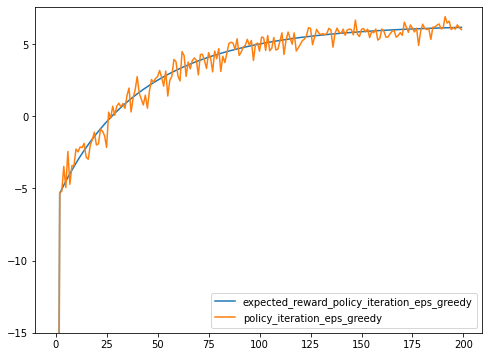

100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


In [12]:
gamma = 0.99
epsilon = 0.2
policy = np.ones((n_states, n_actions)) / n_actions
expected_rewards = []
actual_rewards = []

for i in tqdm(range(200)):
    # policy evaluation stage
    Q = mdp.get_value(policy, gamma)
    expected_reward = ((Q * policy).sum(1) * env.isd).sum()
    actual_rewards.append(evaluate_online(env, policy, gamma=gamma))
    expected_rewards.append(expected_reward)
    # policy improvement stage
    policy = eps_greedy(Q, eps=epsilon)
    
    epsilon *= 0.98
    show_progress(
        expected_reward_policy_iteration_eps_greedy=expected_rewards,
        policy_iteration_eps_greedy=actual_rewards,
    )

In [13]:
from time import sleep
s = env.reset()
clear_output(True)
env.render()
done = False
i = 0
while not done:
    a = np.random.choice(n_actions, p=policy[s])
    s, reward, done, info = env.step(a)
    clear_output(True)
    env.render()
    print(f'step={i}, state={s}, action={a}, reward={reward}')
    sleep(0.5)
    i += 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
step=11, state=475, action=5, reward=20
